In [4]:
import h5py
import numpy as np
import puma
import matplotlib.pyplot as plt
from puma import Histogram, HistogramPlot, Roc, RocPlot
from puma.metrics import calc_rej
from puma.utils import get_good_colours, get_good_linestyles, logger
from sklearn import metrics
from numpy.lib.recfunctions import structured_to_unstructured as s2u

In [16]:
networks = {
    # "GN1Tau" : "logs/GN1_tau_20230215-T172736/ckpts/epoch=021-val_loss=0.31938__test_ttbar.h5"
    # 'GN1Tau': "logs/GN1_tau_20230321-T145044/ckpts/epoch=018-val_loss=0.08698__test_inclusive_testing_ttbar_PFlow.h5"
    # 'GN1Tau' : "logs/GN1_tau_20230325-T210222/ckpts/epoch=023-val_loss=0.07746__test_inclusive_testing_ttbar_PFlow.h5"
   
    # "GN2TauJ" : "logs/GN2TauJ_20230713-T111312/ckpts/epoch=010-val_loss=0.05086__test_pp_output_test.h5" ,
    # "GN2TauC" : "logs/GN2TauC_20230713-T151458/ckpts/epoch=011-val_loss=0.05114__test_pp_output_test.h5" ,
    # "GN2Tau" : "logs/GN2Tau_20230726-T175600/ckpts/epoch=008-val_loss=0.05920__test_pp_output_test.h5"
    #"GN2Tau" : "logs/GN2Tau_20230508-T191218/ckpts/epoch=021-val_loss=0.07711__test_PFlow.h5"
    # "GN1Tau" : "/storage/agrp/zivka/salt/run/logs/GN1_tau_20230226-T104411/ckpts/epoch=028-val_loss=0.28814__test_inclusive_testing_ttbar_PFlow.h5",
    # "GN1Tau + Aux" : "logs/GN1_tau_20230218-T231137/ckpts/epoch=028-val_loss=0.28814__test_ttbar.h5"
    "GN2TauA": "/storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=012-val_loss=0.05973__test_pp_output_test.h5"
}

reference = "RNN"
# reference  = 'GN2Tau'

test_path =  '/storage/agrp/dreyet/GNtau/samples/v04/output/pp_output_test.h5'
#test_path = '/storage/agrp/zivka/umami_Tau/UPP/umami-preprocessing/upp/output_1/pp_output_test.h5'
#'/storage/agrp/dmitrykl/tauTag/upp/output/pp_output_test.h5'
results = {}

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    # you can adapt this for your needs
    return np.log((arr[0] + 1e-10))# / (arr[1] + 1e-10))

with h5py.File(test_path, 'r') as test_f:
    print(test_f['tracks'][0].dtype)
    jet_pt = test_f['jets']['pt'] / 1000
    jet_eta = test_f['jets']['absEta']
    jet_flav = test_f['jets']['HadronConeExclTruthLabelID']
    rnn_pTau = test_f['jets']['TAU_RNNJetScoreSigTrans'] #using Trans Score!!!
    rnn_pBkg = 1 - test_f['jets']['TAU_RNNJetScoreSigTrans']
    track_scores = [test_f['tracks']['rnn_fakeScore'], test_f['tracks']['rnn_chargedScore'], test_f['tracks']['rnn_isolationScore'], test_f['tracks']['rnn_conversionScore']]
    #print(track_scores, '*')
    track_valids = test_f['tracks']['valid']
    #print(track_valids)
    track_truth = test_f['tracks']['NewTruthType']
    n_tracks = np.sum(track_valids, axis=-1)
    #print(n_tracks)
    prongs = np.sum(np.argmax(np.stack(track_scores,axis=-1), axis=-1)==1, axis=-1)
    #print(prongs, '^')
    # prongs = np.sum(track_truth == 1, axis=-1)
    eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
    mask = (rnn_pTau >= 0) & (rnn_pBkg >= 0) & (jet_pt > 20) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
    is_tau = jet_flav == 5
    is_bkg = jet_flav == 0
    n_jets_bkg = np.sum(is_bkg & mask)
    rnn_discs = disc_fct(np.row_stack([rnn_pTau, rnn_pBkg]))

    x = test_f['tracks']['tauTruthProng']
    sig_1_prong = np.isin(x, 1)
    sig_mask_1 = np.any(sig_1_prong, axis=1)
    sig_3_prong = np.isin(x, 3)
    sig_mask_3 = np.any(sig_3_prong, axis=1)

    # rnn_discs = rnn_pTau
    sig_eff = np.linspace(0.4, 1, 20)
    logger.info("Calculate rejection")
    rnn_rej = calc_rej(rnn_discs[is_tau & mask], rnn_discs[is_bkg & mask], sig_eff)
    rnn_rej_0 = calc_rej(rnn_discs[is_tau & mask], rnn_discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
    # rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)], rnn_discs[is_bkg & mask], sig_eff) ##without TauTruthProng mask
    # rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)], rnn_discs[is_bkg & mask], sig_eff) ##without TauTruthProng mask
    rnn_rej_1 = calc_rej(rnn_discs[is_tau & mask & (prongs==1)& sig_mask_1], rnn_discs[is_bkg & mask], sig_eff)
    rnn_rej_3 = calc_rej(rnn_discs[is_tau & mask & (prongs==3)& sig_mask_3], rnn_discs[is_bkg & mask], sig_eff)
    results["RNN"] = {
            'sig_eff' : sig_eff,
            'disc' : rnn_discs,
            'rej' : rnn_rej,
            'rej_0' : rnn_rej_0,
            'rej_1' : rnn_rej_1,
            'rej_3' : rnn_rej_3,
            'pTau' : rnn_pTau,
            'pBkg' : rnn_pBkg,
            'prongs' : prongs,
        }

[('beamSpotWeight', '<f4'), ('TruthType', '<f4'), ('NewTruthType', '<f4'), ('truthJetType', '<f4'), ('z0sinthetaSigTJVA', '<f4'), ('z0sinthetaTJVA', '<f4'), ('d0SigTJVA', '<f4'), ('d0TJVA', '<f4'), ('z0TJVA', '<f4'), ('dz0_TV_PV0', '<f4'), ('log_sumpt_TV', '<f4'), ('log_sumpt2_TV', '<f4'), ('log_sumpt_PV0', '<f4'), ('log_sumpt2_PV0', '<f4'), ('isLRT', '<f4'), ('jetSeedPt', '<f4'), ('jetSeedEta', '<f4'), ('jetSeedPhi', '<f4'), ('tauPt', '<f4'), ('tauEta', '<f4'), ('tauPhi', '<f4'), ('dEtaJetSeedAxis', '<f4'), ('dPhiJetSeedAxis', '<f4'), ('dRJetSeedAxis', '<f4'), ('tauPtIntermediateAxis', '<f4'), ('dRIntermediateAxis', '<f4'), ('tauPtDetectorAxis', '<f4'), ('dRDetectorAxis', '<f4'), ('rConv', '<f4'), ('rConvII', '<f4'), ('charge', '<f4'), ('tauTruthCharge', '<f4'), ('tauTruthProng', '<f4'), ('tauTruthDecayMode', '<f4'), ('truthParticleOrigin', '<f4'), ('truthParticleType', '<f4'), ('trackPt', '<f4'), ('trackEta', '<f4'), ('trackPhi', '<f4'), ('truthE', '<f4'), ('numberOfInnermostPixelLay

INFO:puma: Calculate rejection


In [14]:
with h5py.File(test_path, 'r') as test_f:

    x = test_f['jets']#['tauTruthProng']

(array([9060281.,       0.,       0.,       0.,       0., 3089148.,
              0.,       0.,       0.,   22403.]),
 array([1.        , 1.39999998, 1.79999995, 2.20000005, 2.5999999 ,
        3.        , 3.4000001 , 3.79999995, 4.19999981, 4.5999999 ,
        5.        ]),
 <BarContainer object of 10 artists>)

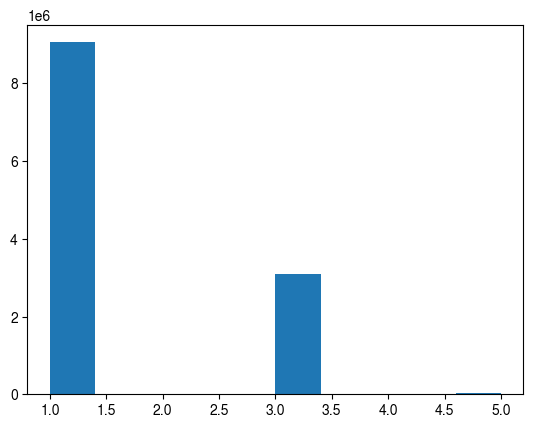

In [9]:
with h5py.File(test_path, 'r') as test_f:
    x = test_f['tracks']['tauTruthProng']
x = x[is_tau]
x = x.flatten()
plt.hist(x)

In [ ]:
np.unique(track_truth)

In [ ]:
track_scores = np.stack(track_scores,axis=-1)

In [ ]:
prongs = np.argmax(np.stack(track_scores,axis=-1), axis=-1)


In [ ]:
prongs

In [ ]:
np.argmax(np.stack(track_scores,axis=-1), axis=-1)

In [ ]:
(mask & (jet_pt > 20) & is_bkg & (prongs == 1)).sum()

In [10]:
plt.hist(discs[mask & is_bkg & (prongs == 3)], density=True, histtype='step')
plt.hist(discs[mask & is_tau & (prongs == 3)], density=True, histtype='step')
plt.show()

NameError: name 'discs' is not defined

In [ ]:
np.sum(eta_mask)

In [ ]:
calc_rej(rnn_discs[is_tau & mask & (prongs==1)], rnn_discs[is_bkg & mask & (prongs==1)], np.array([0.6, 0.75, 0.85, 0.95]))

In [ ]:
rnn_discs[is_tau & mask & (prongs==3)]

In [ ]:
rnn_discs[is_bkg & mask & (prongs==3)]

In [ ]:
calc_rej(rnn_discs[is_tau & mask & (prongs==3)], rnn_discs[is_bkg & mask & (prongs==3)], np.array([0.45, 0.6, 0.75, 0.95]))

In [ ]:
np.sum(is_tau & mask & (prongs==3)) / (np.sum(is_tau & mask)) * 100

In [ ]:
discs[is_tau & mask & (prongs==1)]

In [ ]:
np.sum((prongs==1) & mask & is_tau)

In [ ]:
track_truth[track_valids]

In [ ]:
np.sum(np.argmax(np.stack(track_scores,axis=-1), axis=-1)==1, axis=-1)

In [18]:
logger.info("Calculate discriminants and rejection")
for key, val in networks.items():
    print(key, val)
    with h5py.File(val, 'r') as f:
        #if key == 'GN2TauJ':
            pt = f['jets']['pt'] / 1000
            # tracks_pred = f['tracks'].fields(['0', '1', '2', '3', '4', '5', '6'])[:]
            flav = f['jets']['HadronConeExclTruthLabelID']
            is_tau = flav == 5
            is_bkg = flav == 0
            print(f['jets'][0].dtype)
            if key == 'GN2Tau':
                pTau = f['jets']['GN2Tau_pb']
                pBkg = f['jets']['GN2Tau_pu']
                discs = disc_fct(np.row_stack([pTau, pBkg]))
                print(discs, key)
            if key == 'GN2TauA':
                pTau = f['jets']['GN2TauA_pb']
                pBkg = f['jets']['GN2TauA_pu']
                discs = disc_fct(np.row_stack([pTau, pBkg]))
                print(discs, key)
            if key == 'GN2TauJ':
                pTau = f['jets']['GN2TauJ_pb']
                pBkg = f['jets']['GN2TauJ_pu']
                discs = disc_fct(np.row_stack([pTau, pBkg]))
                print(discs, key)
            if key == 'GN2TauC':
                pTau = f['jets']['GN2TauC_pb']
                pBkg = f['jets']['GN2TauC_pu']
                discs = disc_fct(np.row_stack([pTau, pBkg]))
                print(discs, key)
            # discs = pTau
            # mask = (pt > 20) & (pt < 100)
            # mask = (pt > 5)
            eta_mask = (jet_eta < 2.5) & ((jet_eta > 1.57) | (jet_eta < 1.37))
            mask = (pt > 20) & eta_mask #& ((n_tracks == 1) | (n_tracks == 3))# & (jet_pt < 100)
            sig_eff = np.linspace(0.4, 1, 20)
            logger.info("Calculate rejection")
            rej = calc_rej(discs[is_tau & mask], discs[is_bkg & mask], sig_eff)
            rej_0 = calc_rej(discs[is_tau & mask], discs[is_bkg & mask & (prongs!=1) & (prongs!=3)], sig_eff)
            # rej_1 = calc_rej(discs[is_tau & mask & (prongs==1)], discs[is_bkg & mask], sig_eff)
            # rej_3 = calc_rej(discs[is_tau & mask & (prongs==3)], discs[is_bkg & mask], sig_eff)
            rej_1 = calc_rej(discs[is_tau & mask & (prongs==1) & sig_mask_1], discs[is_bkg & mask], sig_eff)
            rej_3 = calc_rej(discs[is_tau & mask & (prongs==3) & sig_mask_3], discs[is_bkg & mask], sig_eff)
            #print((mask & (jet_pt > 20) & is_bkg & (prongs == 3)).sum())
            results[key] = {
                    'sig_eff' : sig_eff,
                    'disc' : discs,
                    'rej' : rej,
                    'rej_0' : rej_0,
                    'rej_1' : rej_1,
                    'rej_3' : rej_3,
                    'pTau' : rnn_pTau,
                    'pBkg' : rnn_pBkg,
                }



INFO:puma: Calculate discriminants and rejection


GN2TauA /storage/agrp/dreyet/GNtau/salt/logs/GN2TauA_20230918-T144357/ckpts/epoch=012-val_loss=0.05973__test_pp_output_test.h5
[('GN2TauA_pu', '<f4'), ('GN2TauA_pb', '<f4'), ('pt', '<f4'), ('absEta', '<f4'), ('HadronConeExclTruthLabelID', '<f4')]


INFO:puma: Calculate rejection


[-1.1280774e+01 -1.1528841e+01 -1.2899109e+01 ... -8.6628304e+00
 -2.3722929e-05 -9.1063299e+00] GN2TauA


In [ ]:
(mask & (jet_pt > 20) & is_bkg & (prongs == 3)).sum()

KeyError: 'Unable to synchronously open object (invalid identifier type to function)'

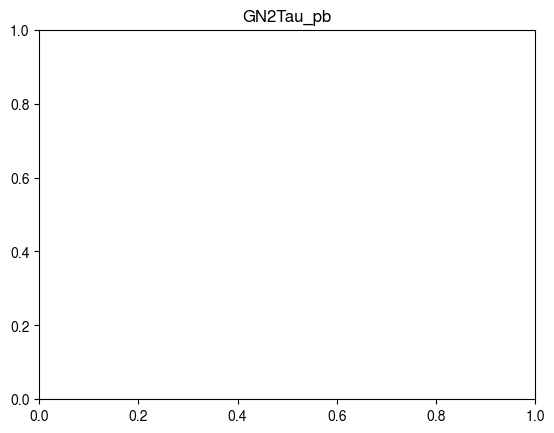

In [19]:
plt.figure()
plt.title('GN2Tau_pb')
plt.hist(f['jets']['GN2Tau_pb'])
plt.figure()
plt.title('GN2Tau_pu')
plt.hist(f['jets']['GN2Tau_pu'], color = 'g')



In [21]:
confusion_matrix = metrics.confusion_matrix(valid_truth, np.argmax(new_pred, axis=-1), normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

NameError: name 'new_pred' is not defined

In [ ]:
rnn_scores = np.stack([track_scores[0], track_scores[1], track_scores[3], track_scores[2]], axis=-1)

In [ ]:
confusion_matrix = metrics.confusion_matrix(valid_truth, np.argmax(rnn_scores[track_valids], axis=-1), normalize='true')

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

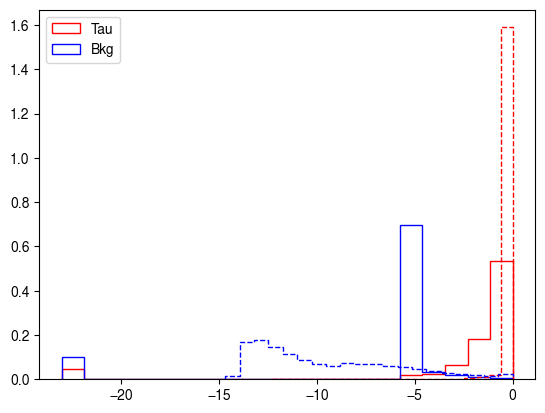

In [23]:
plt.hist(results['RNN']['disc'][is_tau & mask], histtype='step', density=True, bins=20, color='red', label='Tau')
plt.hist(results['RNN']['disc'][is_bkg & mask], histtype='step', density=True, bins=20, color='blue', label='Bkg')
plt.hist(results['GN2TauA']['disc'][is_tau & mask], histtype='step', density=True, bins=20, color='red', linestyle=('dashed'))
plt.hist(results['GN2TauA']['disc'][is_bkg & mask], histtype='step', density=True, bins=20, color='blue', linestyle=('dashed'))
plt.legend()
plt.show()

In [ ]:

def count(lst):
    return sum(not(bool(x)) for x in lst)


In [24]:
plt.rcParams.update({
    "figure.facecolor":  "w", 
    "axes.facecolor":    "w", 
    "savefig.facecolor": "w", 
})

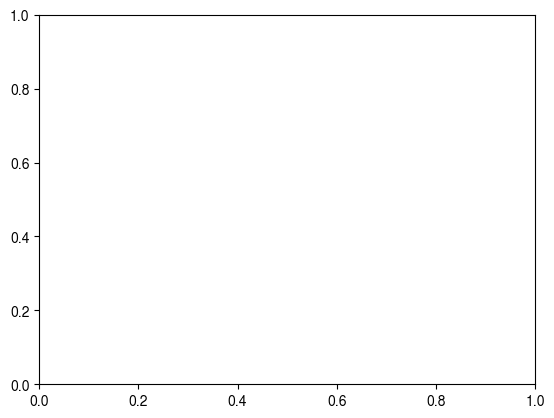

In [33]:
plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n1-prong",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

#for network in results.keys():
plot_roc.add_roc(
    Roc(
        sig_eff,
        results['RNN']['rej_1'],
        n_test=np.sum(is_bkg & mask & (prongs==1)),
        rej_class="qcd",
        signal_class='$\\tau$-jets',
        label=f"{'RNN'}",
    ),
    reference=(reference == 'RNN'),
)
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd")
#plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"onlyRNN_1.png", transparent=False)

In [27]:
plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

for network in results.keys():
    plot_roc.add_roc(
        Roc(
            sig_eff,
            results[network]['rej'],
            n_test=n_jets_bkg,
            rej_class="qcd",
            signal_class='$\\tau$-jets',
            label=f"{network}",
        ),
        reference=(reference == network),
    )
plot_roc.set_ratio_class(1, "qcd",'')
plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"****newnew_roc_tau.png", transparent=False)

TypeError: set_ratio_class() takes 3 positional arguments but 4 were given

In [ ]:
for network in results.keys():
    print(count(results[network]['rej']))

In [ ]:
# plt.hist(pt, bins=100, density=True, range=(0, 1000))
# plt.yscale('log')
# plt.show()
# plot_roc = RocPlot(
#         n_ratio_panels=1,
#         ylabel="Background rejection",
#         xlabel="$\\tau$-jet efficiency",
#         atlas_second_tag="$\\sqrt{s}=13$ TeV",
#         figsize=(6.5, 6),
#         y_scale=1.4,
#     )
# for network in results.keys():
#     if network == 'RNN':
#         lst = np.isinf(results[network]['rej_0'])
#         length_nedded = count(lst)
#     lst = np.isinf(results[network]['rej_0'])
#     num = count(lst)
#     temp_rej_lst = results[network]['rej_0'][-num:]
#     temp_rej_lst = np.pad(temp_rej_lst, (length_nedded-num,0), 'constant', constant_values=results[network]['rej_0'][-num])
#     temp_sig_lst = sig_eff[-num:]
#     temp_sig_lst = np.pad(temp_sig_lst, (length_nedded-num,0), 'constant', constant_values=temp_sig_lst[-num])
#     plot_roc.add_roc(
#         Roc(
#             temp_sig_lst,
#             temp_rej_lst,
#             n_test=n_jets_bkg,
#             rej_class="qcd",
#             signal_class='$\\tau$-jets',
#             label=f"{network}",
#         ),
#         reference=(reference == network),
#     )
# plot_roc.set_ratio_class(1, "qcd",'')
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
# plot_roc.draw()
# plot_roc.savefig(f"roc_tau_0.png", transparent=False)

In [ ]:
mask = pt > 5

In [28]:
##plot only RNN for 1/3 prong

plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n1-prong",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

plot_roc.add_roc(
    Roc(
        sig_eff,
        results['RNN']['rej_1'],
        n_test=np.sum(is_bkg & mask & (prongs==1)),
        rej_class="qcd",
        signal_class='$\\tau$-jets',
        label=f"{'RNN'}",
    ),
    reference=(reference == 'RNN'),
)
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd", label = "")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"^1_alone.png", transparent=False)

TypeError: set_ratio_class() got an unexpected keyword argument 'label'

In [ ]:
results['GN2TauJ']['disc']

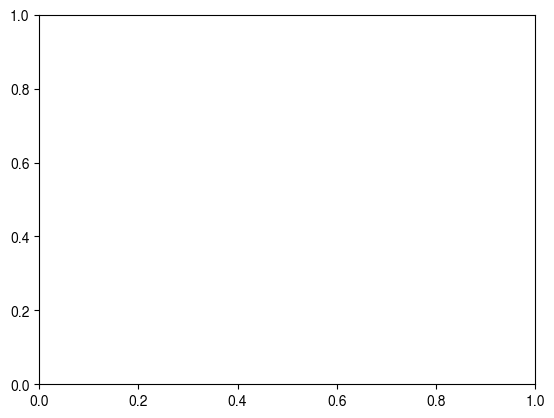

In [26]:
plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n1-prong",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

for network in results.keys():
    plot_roc.add_roc(
        Roc(
            sig_eff,
            results[network]['rej_1'],
            n_test=np.sum(is_bkg & mask & (prongs==1)),
            rej_class="qcd",
            signal_class='$\\tau$-jets',
            label=f"{network}",
        ),
        reference=(reference == network),
    )
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd","")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"*^^*newnew_roc_tau_1.png", transparent=False)

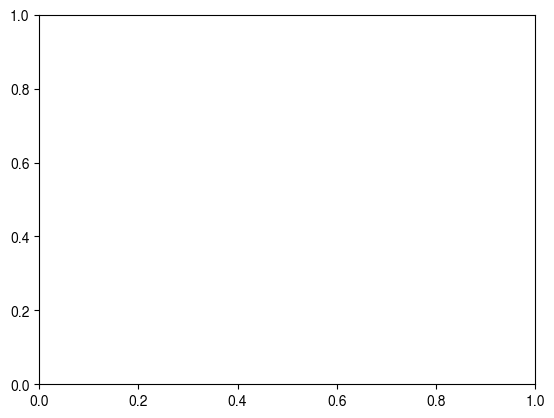

In [27]:
plot_roc = RocPlot(
        n_ratio_panels=1,
        ylabel="Background rejection",
        xlabel="$\\tau$-jet efficiency",
        atlas_second_tag="$\\sqrt{s}=13$ TeV\n3-prong",
        figsize=(6.5, 6),
        y_scale=1.4,
    )

for network in results.keys():
    plot_roc.add_roc(
        Roc(
            sig_eff,
            results[network]['rej_3'],
            n_test=np.sum(is_bkg & mask & (prongs==3)),
            rej_class="qcd",
            signal_class='$\\tau$-jets',
            label=f"{network}",
        ),
        reference=(reference == network),
    )
# setting which flavour rejection ratio is drawn in which ratio panel
plot_roc.set_ratio_class(1, "qcd","")
# plot_roc.set_leg_rej_labels("qcd", "Background rejection")
plot_roc.draw()
plot_roc.savefig(f"*^^*newnew_roc_tau_3.png", transparent=False)

In [ ]:
np.sum(is_tau & mask & (prongs==1) & sig_mask_1)

In [4]:
import numpy as np

from puma import VarVsEff, VarVsEffPlot
from puma.utils import get_dummy_2_taggers, logger

In [5]:
rnn_mask = (rnn_pTau >= 0) & (rnn_pBkg >= 0) & (jet_pt > 20) & eta_mask
mask = (jet_pt > 20) & eta_mask

In [ ]:
np.sum(np.isinf(jet_pt[is_bkg & rnn_mask& (prongs==3)]==True))

In [ ]:
results["GN2TauC"]['disc'][is_bkg & rnn_mask& (prongs==1)]

In [ ]:
prongs_truth = np.sum(track_truth == 1, axis=-1)

In [ ]:
track_truth

In [ ]:
len(np.sum(track_truth == 1, axis = -1) == 1)

In [ ]:
np.sum((prongs==1))

In [ ]:
np.sum((prongs==1) & (np.sum(track_truth == 1, axis = -1) == 1))

In [ ]:
(658197-586729)/658197

In [6]:
prongness = {'1 prongs':[(prongs==1) ,sig_mask_1, 0.75, 1], '3 prongs' : [(prongs==3), sig_mask_3, 0.6, 3]}
#eff = {'1 prongs' : , '3 prongs' : 0.6}

INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


sum:  4 cut:  -1.268835872411728 arr:  [-4.6544805 -4.6376033 -4.6570754] len:  194
sum:  0 cut:  -1.268835872411728 arr:  [-4.670549  -4.6701117 -4.670021 ] len:  70
sum:  0 cut:  -1.268835872411728 arr:  [-4.3450484 -4.6676564 -4.672538 ] len:  58
sum:  1 cut:  -1.268835872411728 arr:  [-4.674936  -4.683157  -4.6702995] len:  50
sum:  0 cut:  -1.268835872411728 arr:  [-4.662219  -4.6840415 -4.704156 ] len:  30
sum:  0 cut:  -1.268835872411728 arr:  [-4.701975 -3.24982  -4.692514] len:  20
sum:  0 cut:  -1.268835872411728 arr:  [-4.6921587 -4.691023  -4.6927733] len:  10
sum:  0 cut:  -1.268835872411728 arr:  [-4.6648817 -4.563949  -4.3688436] len:  5
sum:  0 cut:  -1.268835872411728 arr:  [-3.5310621 -3.3742723 -4.6973805] len:  3
sum:  4 cut:  -1.268835872411728 arr:  [-4.6544805 -4.6376033 -4.6570754] len:  194
sum:  0 cut:  -1.268835872411728 arr:  [-4.670549  -4.6701117 -4.670021 ] len:  70
sum:  0 cut:  -1.268835872411728 arr:  [-4.3450484 -4.6676564 -4.672538 ] len:  58
sum:  1

INFO:puma: Plotting bkg rejection for inclusive efficiency as a function of pt.


sum:  0 cut:  -0.4651409626007077 arr:  [-4.6183567 -4.619147  -4.620246 ] len:  431
sum:  0 cut:  -0.4651409626007077 arr:  [-4.6224484 -4.626251  -4.633016 ] len:  148
sum:  0 cut:  -0.4651409626007077 arr:  [-4.62044   -4.617892  -4.6194396] len:  97
sum:  0 cut:  -0.4651409626007077 arr:  [-4.6336718 -4.630539  -4.6216936] len:  102
sum:  0 cut:  -0.4651409626007077 arr:  [-4.634939 -4.631641 -4.629739] len:  50
sum:  0 cut:  -0.4651409626007077 arr:  [-4.631637  -4.6281214 -4.6320424] len:  28
sum:  0 cut:  -0.4651409626007077 arr:  [-4.617841 -4.632698 -4.630539] len:  16
sum:  0 cut:  -0.4651409626007077 arr:  [-4.630462  -4.6241226 -4.5709977] len:  10
sum:  0 cut:  -0.4651409626007077 arr:  [-4.632453  -4.220097  -4.6247215] len:  6
sum:  0 cut:  -0.4651409626007077 arr:  [-4.6183567 -4.619147  -4.620246 ] len:  431
sum:  0 cut:  -0.4651409626007077 arr:  [-4.6224484 -4.626251  -4.633016 ] len:  148
sum:  0 cut:  -0.4651409626007077 arr:  [-4.62044   -4.617892  -4.6194396] len

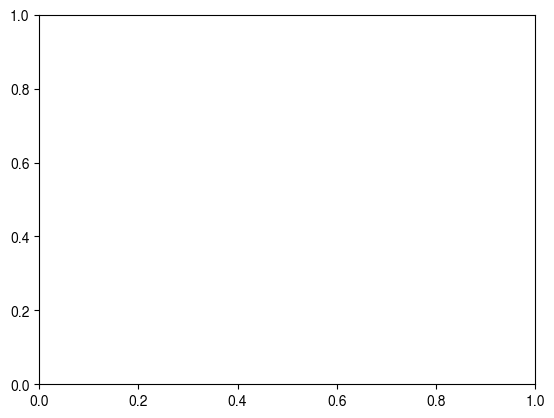

In [8]:
#for network in results.keys(): 
for p_num,sigi, eff, prong in prongness.values():
    # if network == 'RNN':
    #     continue
    # define the curves
    #print(network)
    rnnip_light = VarVsEff(
        x_var_sig=jet_pt[is_tau & rnn_mask & p_num & sigi],
        disc_sig=results["RNN"]['disc'][is_tau & rnn_mask & p_num & sigi],
        x_var_bkg=jet_pt[is_bkg & rnn_mask & p_num],
        disc_bkg=results["RNN"]['disc'][is_bkg & rnn_mask & p_num],
        bins=[100, 200, 300, 400, 500, 600, 700,800, 900,1000],
        #bins=[20, 30, 40, 60, 85, 110, 140, 175, 250],
        working_point=eff,
        disc_cut=None,
        fixed_eff_bin=False,
        label="RNN"
        )
        # dips_light = VarVsEff(
        #     x_var_sig=jet_pt[is_tau & mask & p_num],
        #     disc_sig= results[network]['disc'][is_tau & mask & p_num],
        #     x_var_bkg=jet_pt[is_bkg & mask],
        #     disc_bkg=results[network]['disc'][is_bkg & mask],
        #     bins=[20, 30, 40, 60, 85, 110, 140, 175, 250],
        #     working_point=eff,
        #     disc_cut=None,
        #     fixed_eff_bin=False,
        #     label=network,
        # )


    logger.info("Plotting bkg rejection for inclusive efficiency as a function of pt.")
    # You can choose between different modes: "sig_eff", "bkg_eff", "sig_rej", "bkg_rej"
    plot_bkg_rej = VarVsEffPlot(
        mode="bkg_rej",
        ylabel="BKG-jets rejection",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, $f_{c}=0.018, " + "prongs = {}".format(prong),
        n_ratio_panels=1,
    )
    plot_bkg_rej.add(rnnip_light, reference=True)
#        plot_bkg_rej.add(dips_light)

    plot_bkg_rej.draw()
    plot_bkg_rej.savefig('p_only'+str(prong)+"_BKG_rej.png")

    plot_sig_eff = VarVsEffPlot(
        mode="sig_eff",
        ylabel="$Tau$-jets efficiency",
        xlabel=r"$p_{T}$ [GeV]",
        logy=False,
        atlas_second_tag="$\\sqrt{s}=13$ TeV, $f_{c}=0.018$, " + 'prongs = {}'.format(prong) ,
        n_ratio_panels=1,
    )
    plot_sig_eff.add(rnnip_light, reference=True)
#    plot_sig_eff.add(dips_light)

    plot_sig_eff.atlas_second_tag += "\nInclusive $\\epsilon_b={}%%$".format(eff)

    # If you want to inverse the discriminant cut you can enable it via
    # plot_sig_eff.set_inverse_cut()
    plot_sig_eff.draw()
    # Drawing a hline indicating inclusive efficiency
    plot_sig_eff.draw_hline(eff)
    plot_sig_eff.savefig('p_only'+str(prong)+"_tau_eff.png", transparent=False)

In [ ]:
plt.hist(jet_pt)

In [ ]:
plt.hist(jet_pt[is_bkg & rnn_mask & (prongs==3)], bins = 30, log = True)

In [ ]:
plt.hist(results['GN2Tau']['disc'][is_tau & mask & (prongs==3)], bins = 30, log = True)